In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.signal import stft
import os
import pandas as pd
import sys
import glob
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from ipynb.fs.full.CNN_model import CNN_Model, Evaluator,BlandAltman, normalize_data, denormalize_data
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
import tensorflow as tf
import random
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
def set_seeds(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

seed_value = 20
set_seeds(seed_value)

In [11]:
data = np.load(r'F:\junwei\CNN\CNN_keras\data.npy')
output_data = pd.read_excel('F:\junwei\dataset\_MASTER_modified.xlsx',usecols=['Crs', 'R'])
train = pd.read_csv(r'F:\junwei\CNN\CNN_keras\train.csv')
test = pd.read_csv(r'F:\junwei\CNN\CNN_keras\test.csv')
val = pd.read_csv(r'F:\junwei\CNN\CNN_keras\val.csv')

In [12]:
volume = data[:,:901,0]
flow = data[:,:901,1]
pressure= data[:,:901,2]
Crs = output_data['Crs']
R = output_data['R']
Crs = Crs.T
R= R.T
flow = flow.T
pressure = pressure.T
volume = volume.T

In [13]:
print('Crs shape is: ', Crs.shape)
print('R shape is: ', R.shape)
print('flow shape is: ', flow.shape)
print('pressure shape is: ',pressure.shape)
print('Volume shape is: ', volume.shape)


Crs shape is:  (442,)
R shape is:  (442,)
flow shape is:  (901, 442)
pressure shape is:  (901, 442)
Volume shape is:  (901, 442)


In [14]:
num_examples = flow.shape[0]
num_samples = flow.shape[1]

(min_flow, max_flow, flow) = normalize_data(flow)
(min_volume, max_volume, volume) = normalize_data(volume)
(min_paw, max_paw, pressure) = normalize_data(pressure)
(min_resistance, max_resistance, R) = normalize_data(R)
(min_capacitance, max_capacitance, Crs) = normalize_data(Crs)

In [15]:
Crs = np.array(Crs).reshape(-1, 1)  # Reshape to (442, 1)
R = np.array(R).reshape(-1, 1)  
output_data = np.concatenate((Crs,R),axis=1)
output_data = pd.DataFrame(output_data)
output_data = output_data.rename(columns={0: "Crs", 1: "R"})
signals = np.stack([flow, volume, pressure], axis=2)
signals = np.transpose(signals, (1, 0, 2))

In [16]:
indices_train = train['Unnamed: 0'].values
indices_test = test['Unnamed: 0'].values
indices_val = val['Unnamed: 0'].values
train_input = signals[indices_train,:,:]
test_input = signals[indices_test,:,:]
val_input = signals[indices_val,:,:]
train_output = output_data.loc[indices_train]
test_output = output_data.loc[indices_test]
val_output = output_data.loc[indices_val]

In [17]:
batch_size = 8
num_samples = 309
total_epochs = 150 

updates_per_epoch = num_samples // batch_size
if num_samples % batch_size != 0:
    updates_per_epoch += 1  

decay_steps = updates_per_epoch * total_epochs
decay_steps

5850

In [18]:
model = CNN_Model(signals.shape[1],input_volume = 3).get_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_input, train_output, epochs=150, verbose=1,
                    validation_data=(val_input, val_output),
                    callbacks=[early_stopping])

Epoch 1/150
10/10 [==============================] - 4s 69ms/step - loss: 1.4168 - val_loss: 0.0879
Epoch 2/150
10/10 [==============================] - 0s 25ms/step - loss: 0.8285 - val_loss: 0.0764
Epoch 3/150
10/10 [==============================] - 0s 26ms/step - loss: 0.4908 - val_loss: 0.0725
Epoch 4/150
10/10 [==============================] - 0s 34ms/step - loss: 0.2783 - val_loss: 0.0712
Epoch 5/150
10/10 [==============================] - 0s 40ms/step - loss: 0.1615 - val_loss: 0.0631
Epoch 6/150
10/10 [==============================] - 0s 32ms/step - loss: 0.1028 - val_loss: 0.0637
Epoch 7/150
10/10 [==============================] - 0s 37ms/step - loss: 0.0739 - val_loss: 0.0629
Epoch 8/150
10/10 [==============================] - 0s 36ms/step - loss: 0.0600 - val_loss: 0.0673
Epoch 9/150
10/10 [==============================] - 0s 33ms/step - loss: 0.0462 - val_loss: 0.0654
Epoch 10/150
10/10 [==============================] - 0s 37ms/step - loss: 0.0460 - val_loss: 0.0712

In [19]:
test_predictions = model.predict(test_input)

3/3 [==============================] - 0s 10ms/step


In [20]:
test_predictions[:, 0].shape

(67,)

In [21]:
pre_data_unscaled1  = denormalize_data(test_predictions[:, 0], minimum=min_capacitance, maximum=max_capacitance)
pre_data_unscaled2 = denormalize_data(test_predictions[:, 1], minimum= min_resistance, maximum=max_resistance )
output_data_array = test_output.values
output_data_unscaled1 = denormalize_data(output_data_array[:, 0], minimum=min_capacitance, maximum=max_capacitance)
output_data_unscaled2 = denormalize_data(output_data_array[:, 1], minimum=min_resistance, maximum=max_resistance)

In [22]:
#pre_data_unscaled1 = test_predictions[:, 0]
#pre_data_unscaled2 = test_predictions[:, 1]
#output_data_array = output_test.values
#output_data_unscaled1 = output_data_array[:, 0]
#output_data_unscaled2 = output_data_array[:, 1]

In [23]:
#pre_data_unscaled1 = scaler1.inverse_transform(test_predictions[:, 0].reshape(-1, 1))
#pre_data_unscaled2 = scaler2.inverse_transform(test_predictions[:, 1].reshape(-1, 1))

In [24]:
output_data_unscaled1

array([29.68207007, 37.66634384, 71.60883764, 44.34508799, 55.66840081,
       42.46318195, 42.69832963, 45.05859788, 60.7282361 , 26.89293756,
       39.39666313, 49.98936293, 53.86114235, 42.34923128, 45.25770745,
       35.70934321, 37.89624054, 44.00244674, 43.44367473, 32.43893218,
       43.94855865, 55.22004473, 29.99622476, 47.60288545, 55.62730459,
       28.01969789, 39.15884133, 45.30537023, 89.05635828, 41.19253619,
       40.91474235, 38.72326362, 38.6887359 , 32.58013945, 70.11306543,
       44.84286187, 31.68434957, 31.91032807, 34.76636679, 49.09008545,
       58.06818346, 43.54934276, 30.84813617, 58.67993702, 59.18976456,
       35.06581704, 33.5086331 , 38.43287404, 39.38926041, 43.76606634,
       56.97641268, 48.8231298 , 58.9039239 , 53.93397771, 49.16179748,
       48.48976238, 41.31579748, 40.51348951, 53.77674492, 37.18250078,
       47.98469305, 38.96368414, 41.51242822, 45.55817896, 47.91940255,
       37.13019966, 74.78428187])

In [25]:
#output_data_array = output_test.values
#output_data_unscaled1 = scaler1.inverse_transform(output_data_array[:, 0].reshape(-1, 1))
#output_data_unscaled2 = scaler2.inverse_transform(output_data_array[:, 1].reshape(-1, 1))

In [26]:
# Instantiate the Evaluator class
evaluator_c = Evaluator(output_data_unscaled1, pre_data_unscaled1)
evaluator_r = Evaluator(output_data_unscaled2, pre_data_unscaled2)

# Calculate the evaluation metrics
mse1, mae1, nmse1, mape1, r2_1 = evaluator_c.evaluate()

mse2, mae2, nmse2, mape2, r2_2 = evaluator_r.evaluate()

#print(f'MSE: {mse}')
#print(f'MAE_C: {mae1}')
#print(f'NMSE_C: {nmse1}')
#print(f'MAPE_C: {mape1}%')
#print(f'R_square_C: {r2_1}%')
#print(f'MAE_R: {mae2}')
#print(f'NMSE_R: {nmse2}')
#print(f'MAPE_R: {mape2}%')
#print(f'R_square_R: {r2_2}%')

In [27]:
evl = {'Metric': ['MSE','MAE', 'NMSE', 'MAPE', 'R-square'],
        'C': [mse1,mae1, nmse1, mape1, r2_1],
        'R': [mse2,mae2, nmse2, mape2, r2_2]}

# Create a DataFrame
results_df = pd.DataFrame(evl)

# Set the index to the 'Metric' column
results_df.set_index('Metric', inplace=True)

# Display the DataFrame
print(results_df)

                   C          R
Metric                         
MSE       192.849930  30.221387
MAE        10.739761   3.741938
NMSE        1.202980   1.030719
MAPE       23.113354  26.763393
R-square   -0.447160  -0.062382


                   C          R
Metric                         
MSE       192.849930  30.221387
MAE        10.739761   3.741938
NMSE        1.202980   1.030719
MAPE       23.113354  26.763393
R-square   -0.447160  -0.062382

In [28]:
import numpy as np
import matplotlib.pyplot as plt

class BlandAltman:
    def __init__(self, output_data_unscaled, pre_data_unscaled):
        self.output_data_unscaled = output_data_unscaled
        self.pre_data_unscaled = pre_data_unscaled

    def plot(self, x_label, start, xlim_range,start_y,ylim_range):
        # Convert the values to numpy arrays
        output_data = np.asarray(self.output_data_unscaled)
        pre_data = np.asarray(self.pre_data_unscaled)

        # Calculate the difference and mean
        diff = output_data - pre_data
        mean = (output_data + pre_data) / 2

        # Calculate the percentage difference between predictions and targets
        percentage_diff = (diff / mean) * 100

        # Calculate the mean and standard deviation of the percentage difference
        mean_diff = np.mean(percentage_diff)
        std_diff = np.std(percentage_diff)

        overestimate_indices = []
        underestimate_indices = []
        # Find indices of outliers
        outlier_indices = []

        for i, percentage_error in enumerate(percentage_diff):
            if percentage_error > 20:  # overestimate
                outlier_indices.append(i)
                overestimate_indices.append(i)
            elif percentage_error < -20:  # underestimate
                outlier_indices.append(i)
                underestimate_indices.append(i)

        # Plot the Bland-Altman plot with percentage difference
        fig, ax = plt.subplots(figsize=(8, 5.5))
        for i in range(len(percentage_diff)):
            if i in outlier_indices:
                ax.scatter(output_data[i], percentage_diff[i], color='red', s=15)
            else:
                ax.scatter(output_data[i], percentage_diff[i], color='blue', s=15)
        ax.axhline(mean_diff, color='gray', linestyle='--',lw = 2)
        upper_limit = mean_diff + 1.96 * std_diff
        lower_limit = mean_diff - 1.96 * std_diff
        ax.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--',lw = 2)
        ax.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--',lw = 2)
        ax.axhline(20, color='green', linestyle='-',lw = 2.5)
        ax.axhline(-20, color='green', linestyle='-',lw = 2.5)
        ax.set_xlabel(x_label, fontsize=14)
        ax.set_ylabel('Percentage Difference between Predictions and Targets', fontsize=11)
        #ax.set_title('Bland-Altman Plot', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xlim(start, xlim_range)
        ax.set_ylim(start_y, ylim_range)
        #yticks = np.arange(start_y, ylim_range + 1, 10)  
        #plt.yticks(yticks)
        ax.set_yticks([-60,-50,-40,-30,-20,-10, 0, 10,20,30,40,50,60])
        plt.show()
        print("The Y-coordinate for the upper gray line is: ", upper_limit)
        print("The Y-coordinate for the lower gray line is: ", lower_limit)
        print(f"Mean difference line Y-value: {mean_diff}")
        # Print indices of outliers
        #print("Indices of outliers: ", outlier_indices)
        #print("Indices of overestimations: ", overestimate_indices)
        #print("Indices of underestimations: ", underestimate_indices)
        return outlier_indices, overestimate_indices, underestimate_indices


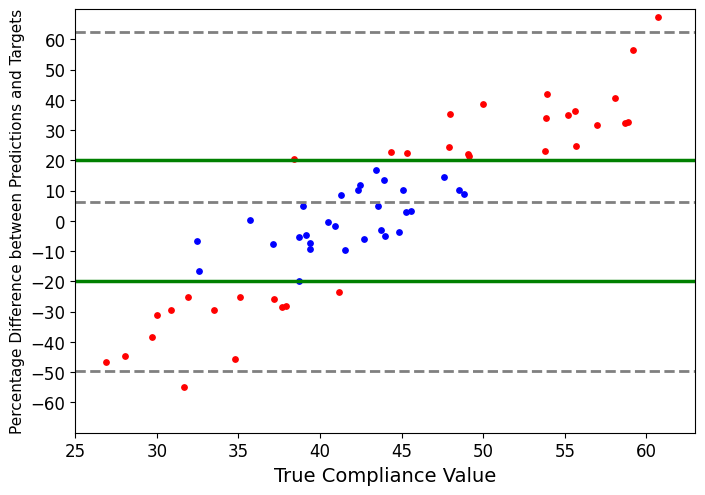

The Y-coordinate for the upper gray line is:  62.39869175225712
The Y-coordinate for the lower gray line is:  -49.619772649306256
Mean difference line Y-value: 6.389459551475431


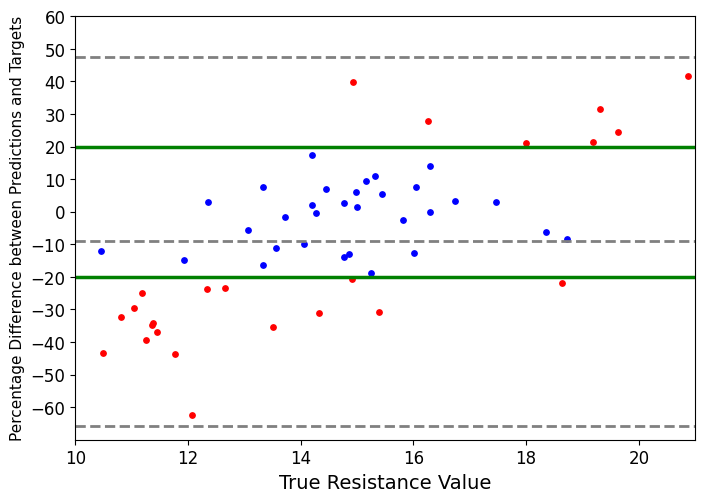

The Y-coordinate for the upper gray line is:  47.49013055668686
The Y-coordinate for the lower gray line is:  -65.65164612956139
Mean difference line Y-value: -9.080757786437262


In [29]:
bland_C = BlandAltman(output_data_unscaled1, pre_data_unscaled1)
bland_R = BlandAltman(output_data_unscaled2, pre_data_unscaled2)

outlier_indices_C = bland_C.plot('True Compliance Value',25,63,-70,70)
outlier_indices_R = bland_R.plot('True Resistance Value',10,21,-70,50) 

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()